In [16]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [43]:
classes = ['class_0','class_1']
class_1_speakers = ['f1','f7','f8','m3','m6','m8']
filepath = 'daps/cleanraw'

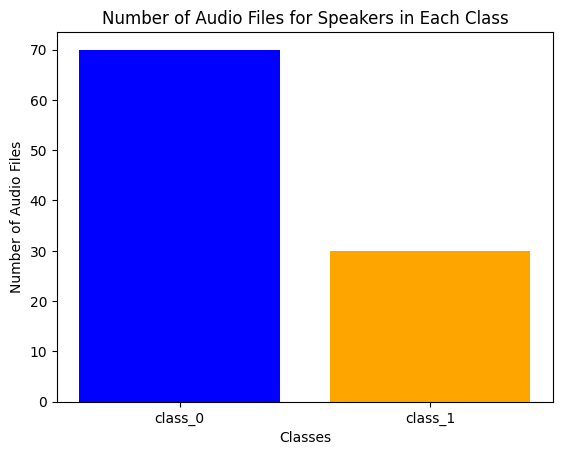

Duration - Mean: 152.9349804988662 Median: 152.40997732426302


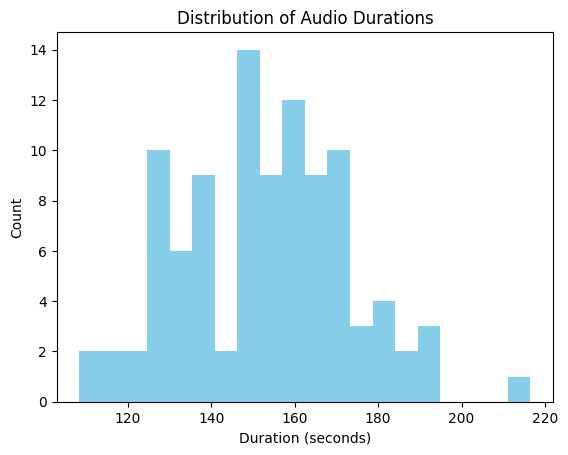

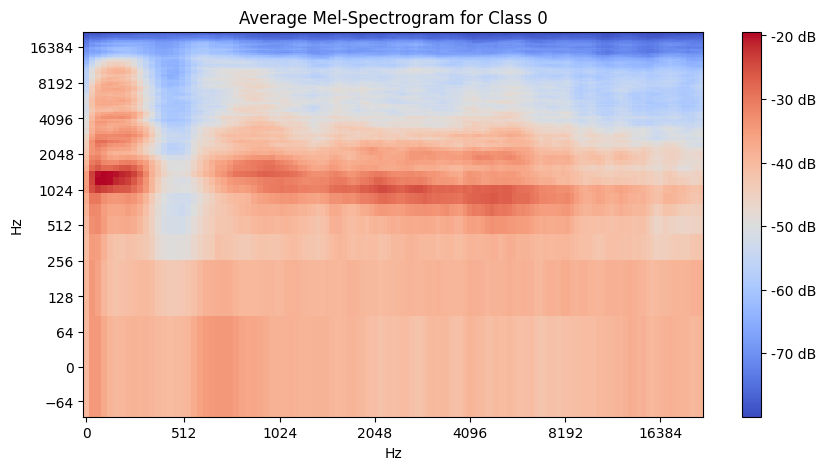

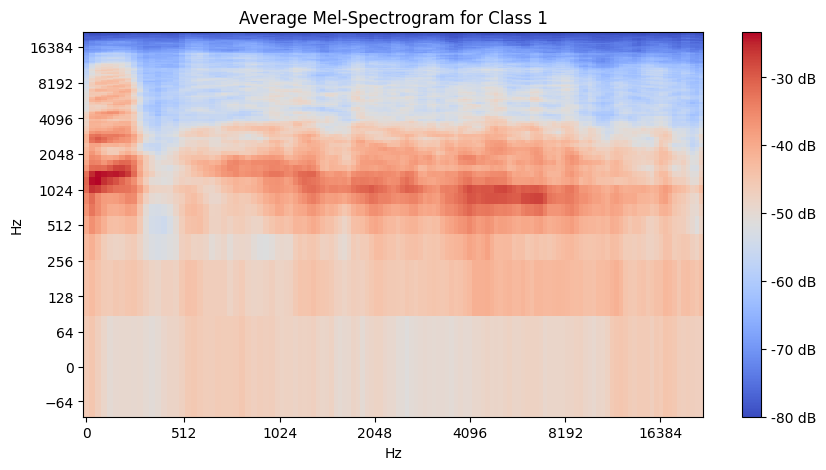

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_19204\1945790984.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['duration'].groupby(df['class']).apply(list), labels=classes)
C:\Users\Mateusz\AppData\Local\Temp\ipykernel_19204\1945790984.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Class')


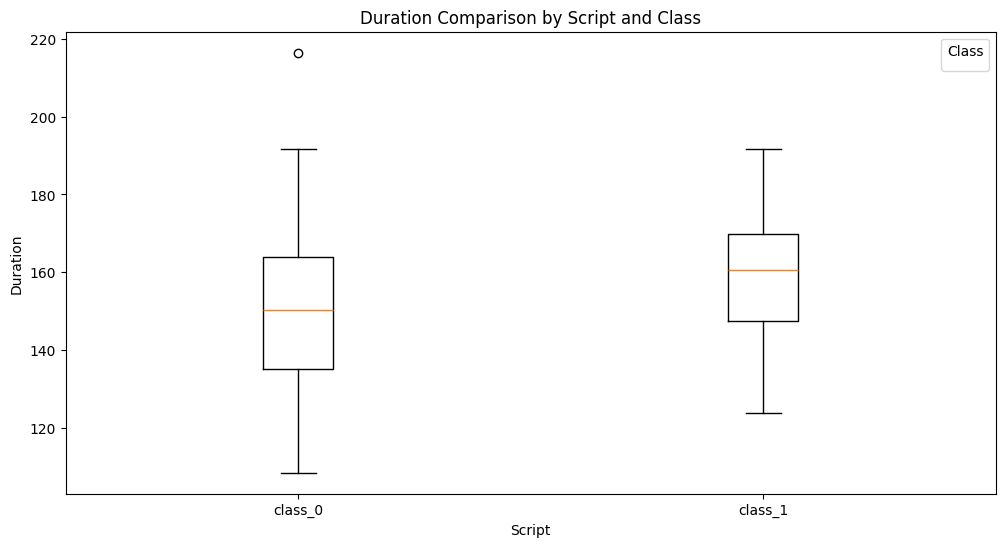

In [7]:
def count_and_plot_speakers(filepath, class_1_speakers):
    data = []
    class_0_spectrograms = []
    class_1_spectrograms = []

    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        S = librosa.feature.melspectrogram(y=trimmed, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        if file.split('_')[0] in class_1_speakers:
            class_1_spectrograms.append(S_dB)
        else:
            class_0_spectrograms.append(S_dB)

        data.append({
            'script': file.split("_")[1],
            'speaker': file.split('_')[0],
            'class': 'class_1' if file.split('_')[0] in class_1_speakers else 'class_0',
            'duration': librosa.get_duration(y=trimmed, sr=sr),
            'sample rate': sr
        })

    # Plotting
    df = pd.DataFrame(data)
    classes = df['class'].unique()

    plt.bar(classes, df['class'].value_counts(), color=['blue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Audio Files')
    plt.title('Number of Audio Files for Speakers in Each Class')
    plt.show()

    print("Duration - Mean:", np.mean(df['duration']), "Median:", np.median(df['duration']))

    # Plot duration distribution
    plt.hist(df['duration'], bins=20, color='skyblue')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.title('Distribution of Audio Durations')
    plt.show()

    # Determine minimum length for spectrograms
    min_length = min(
        min(len(s) for s in class_0_spectrograms) if class_0_spectrograms else float('inf'),
        min(len(s) for s in class_1_spectrograms) if class_1_spectrograms else float('inf')
    )

    # Ensure all spectrograms are the same length by trimming or padding
    class_0_spectrograms = [s[:, :min_length] for s in class_0_spectrograms]
    class_1_spectrograms = [s[:, :min_length] for s in class_1_spectrograms]

    # Calculate mean spectrogram across samples in each class
    mean_class_0 = np.mean(np.array(class_0_spectrograms), axis=0)
    mean_class_1 = np.mean(np.array(class_1_spectrograms), axis=0)

    # Plot average loudness across frequencies for each class
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mean_class_0, sr=sr, x_axis='mel', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Average Mel-Spectrogram for Class 0')
    plt.show()

    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mean_class_1, sr=sr, x_axis='mel', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Average Mel-Spectrogram for Class 1')
    plt.show()

    # Create box plots
    plt.figure(figsize=(12, 6))
    plt.boxplot(df['duration'].groupby(df['class']).apply(list), labels=classes)
    plt.title('Duration Comparison by Script and Class')
    plt.ylabel('Duration')
    plt.xlabel('Script')
    plt.legend(title='Class')
    plt.show()

count_and_plot_speakers(filepath, class_1_speakers)

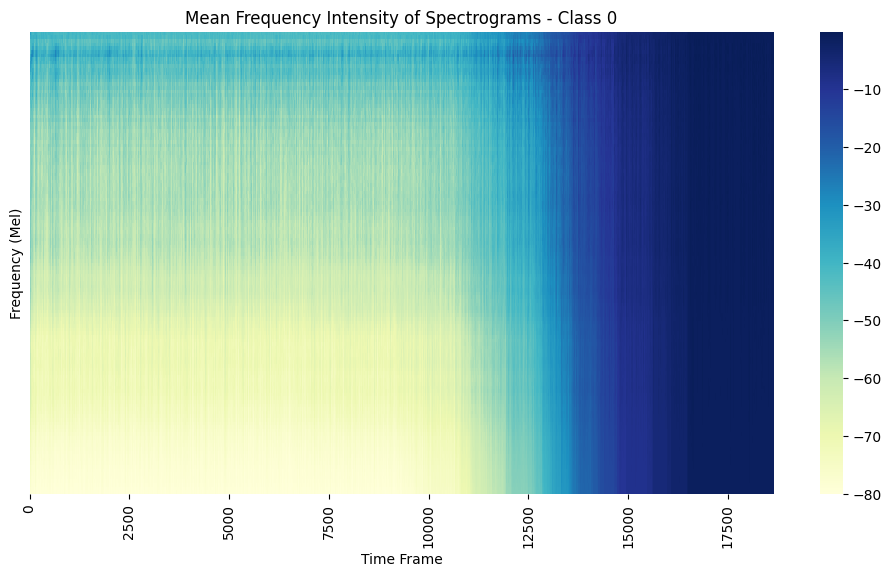

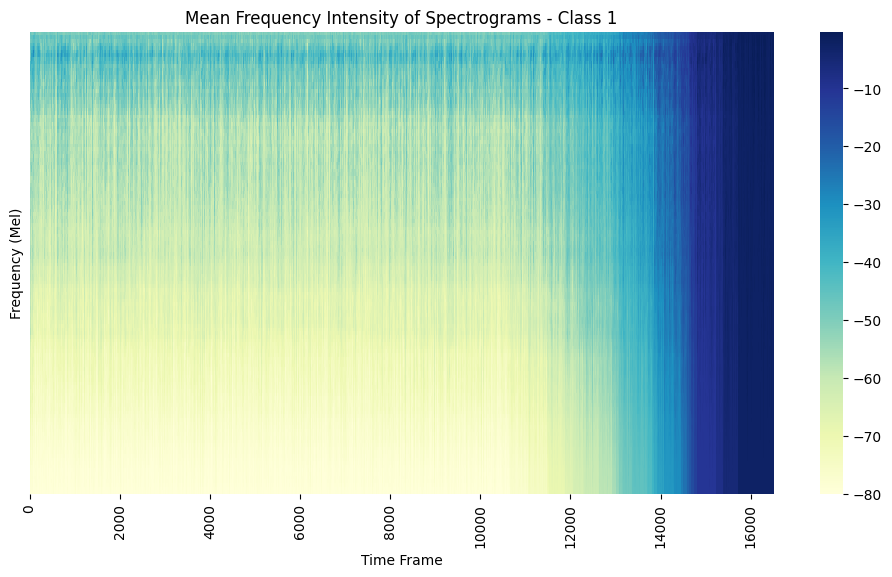

In [23]:
def plot_frequency_intensity(filepath, class_1_speakers):
    class_0_spectrograms = []
    class_1_spectrograms = []

    # Load audio files and compute spectrograms
    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        S = librosa.feature.melspectrogram(y=trimmed, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        if file.split('_')[0] in class_1_speakers:
            class_1_spectrograms.append(S_dB)
        else:
            class_0_spectrograms.append(S_dB)

    # Check if we have any spectrograms for both classes
    if not class_0_spectrograms or not class_1_spectrograms:
        print("Not enough data for one or both classes.")
        return

    # Make sure all spectrograms are of the same length for averaging
    max_length_0 = max(s.shape[1] for s in class_0_spectrograms)
    max_length_1 = max(s.shape[1] for s in class_1_spectrograms)

    padded_class_0 = [np.pad(s, ((0, 0), (0, max_length_0 - s.shape[1])), mode='constant') for s in class_0_spectrograms]
    padded_class_1 = [np.pad(s, ((0, 0), (0, max_length_1 - s.shape[1])), mode='constant') for s in class_1_spectrograms]

    # Calculate the mean spectrogram for each class
    mean_class_0 = np.mean(np.array(padded_class_0), axis=0)  # Shape (n_mels, time)
    mean_class_1 = np.mean(np.array(padded_class_1), axis=0)  # Shape (n_mels, time)

    # Frequency bins corresponding to the mel-spectrogram
    n_mels = mean_class_0.shape[0]  # Number of mel bands
    frequency_bins = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr / 2)

    # Create a 2D density plot for Class 0
    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_class_0, cmap='YlGnBu', cbar=True, xticklabels=np.linspace(0, max_length_0, num=10).astype(int), yticklabels=False)
    plt.title('Mean Frequency Intensity of Spectrograms - Class 0')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency (Mel)')
    plt.xscale('linear')  # Use linear scale
    plt.show()

    # Create a 2D density plot for Class 1
    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_class_1, cmap='YlGnBu', cbar=True, xticklabels=np.linspace(0, max_length_1, num=10).astype(int), yticklabels=False)
    plt.title('Mean Frequency Intensity of Spectrograms - Class 1')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency (Mel)')
    plt.xscale('linear')  # Use linear scale
    plt.show()

plot_frequency_intensity(filepath, class_1_speakers)

Class 0 spectrograms count: 70
Class 1 spectrograms count: 30
Mean Class 0 shape: (128, 18647)
Mean Class 1 shape: (128, 18647)
Time shape: (18647,)
Mean Class 0 reduced shape: (18647,)
Mean Class 1 reduced shape: (18647,)


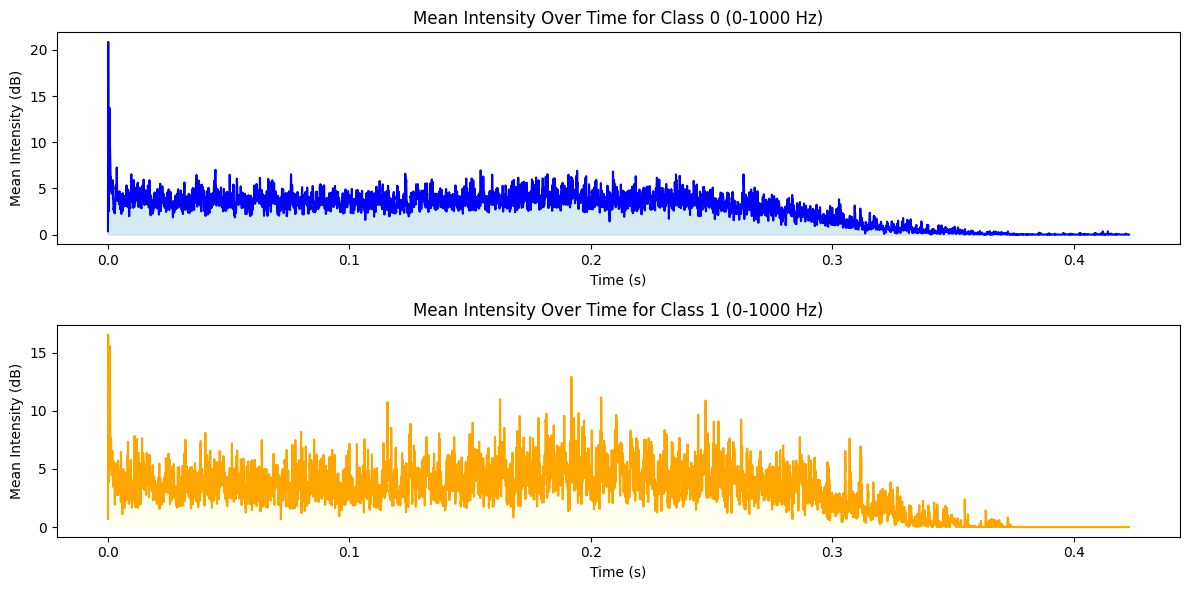

In [33]:
def plot_temporal_intensity(filepath, class_1_speakers):
    class_0_spectrograms = []
    class_1_spectrograms = []
    
    # Load and compute spectrograms
    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        S = librosa.feature.melspectrogram(y=trimmed, sr=sr)
        
        if file.split('_')[0] in class_1_speakers:
            class_1_spectrograms.append(S)
        else:
            class_0_spectrograms.append(S)

    # Check shapes of loaded spectrograms
    print(f"Class 0 spectrograms count: {len(class_0_spectrograms)}")
    print(f"Class 1 spectrograms count: {len(class_1_spectrograms)}")

    # Pad or truncate spectrograms to ensure consistent shapes
    def pad_spectrograms(spectrograms, max_length):
        padded = []
        for s in spectrograms:
            if s.shape[1] < max_length:
                # Pad with zeros on the right
                padded_s = np.pad(s, ((0, 0), (0, max_length - s.shape[1])), mode='constant')
            else:
                # Truncate to max_length
                padded_s = s[:, :max_length]
            padded.append(padded_s)
        return padded

    max_length_class_0 = max(s.shape[1] for s in class_0_spectrograms) if class_0_spectrograms else 0
    max_length_class_1 = max(s.shape[1] for s in class_1_spectrograms) if class_1_spectrograms else 0
    max_length = max(max_length_class_0, max_length_class_1)

    class_0_spectrograms_padded = pad_spectrograms(class_0_spectrograms, max_length)
    class_1_spectrograms_padded = pad_spectrograms(class_1_spectrograms, max_length)

    # Calculate mean spectrogram over time for each class
    mean_class_0 = np.mean(class_0_spectrograms_padded, axis=0)
    mean_class_1 = np.mean(class_1_spectrograms_padded, axis=0)

    # Print shapes of mean spectrograms
    print(f"Mean Class 0 shape: {mean_class_0.shape}")
    print(f"Mean Class 1 shape: {mean_class_1.shape}")

    # Calculate average intensity for a specific frequency band (e.g., 0-1000 Hz)
    frequency_bins = librosa.mel_frequencies(n_mels=mean_class_0.shape[0])
    
    # You can choose the frequency range you want to visualize
    freq_range_indices = frequency_bins <= 1000
    mean_class_0_reduced = mean_class_0[freq_range_indices, :].mean(axis=0)  # Average over frequency
    mean_class_1_reduced = mean_class_1[freq_range_indices, :].mean(axis=0)

    # Time axis based on the number of frames in the mean spectrogram
    time = np.linspace(0, max_length / sr, mean_class_0.shape[1])  # Time for each frame

    # Print shapes for debugging
    print(f"Time shape: {time.shape}")
    print(f"Mean Class 0 reduced shape: {mean_class_0_reduced.shape}")
    print(f"Mean Class 1 reduced shape: {mean_class_1_reduced.shape}")

    # Ensure that the time array matches the number of time frames
    time = time[:mean_class_0_reduced.shape[0]]

    # Plot
    plt.figure(figsize=(12, 6))
    
    # Class 0
    plt.subplot(2, 1, 1)
    plt.plot(time, mean_class_0_reduced, label='Mean Intensity (Class 0)', color='blue')
    plt.fill_between(time, mean_class_0_reduced, color='lightblue', alpha=0.5)
    plt.title('Mean Intensity Over Time for Class 0 (0-1000 Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Intensity (dB)')
    
    # Class 1
    plt.subplot(2, 1, 2)
    plt.plot(time, mean_class_1_reduced, label='Mean Intensity (Class 1)', color='orange')
    plt.fill_between(time, mean_class_1_reduced, color='lightyellow', alpha=0.5)
    plt.title('Mean Intensity Over Time for Class 1 (0-1000 Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Intensity (dB)')

    plt.tight_layout()
    plt.show()

# Example usage
plot_temporal_intensity(filepath, class_1_speakers)

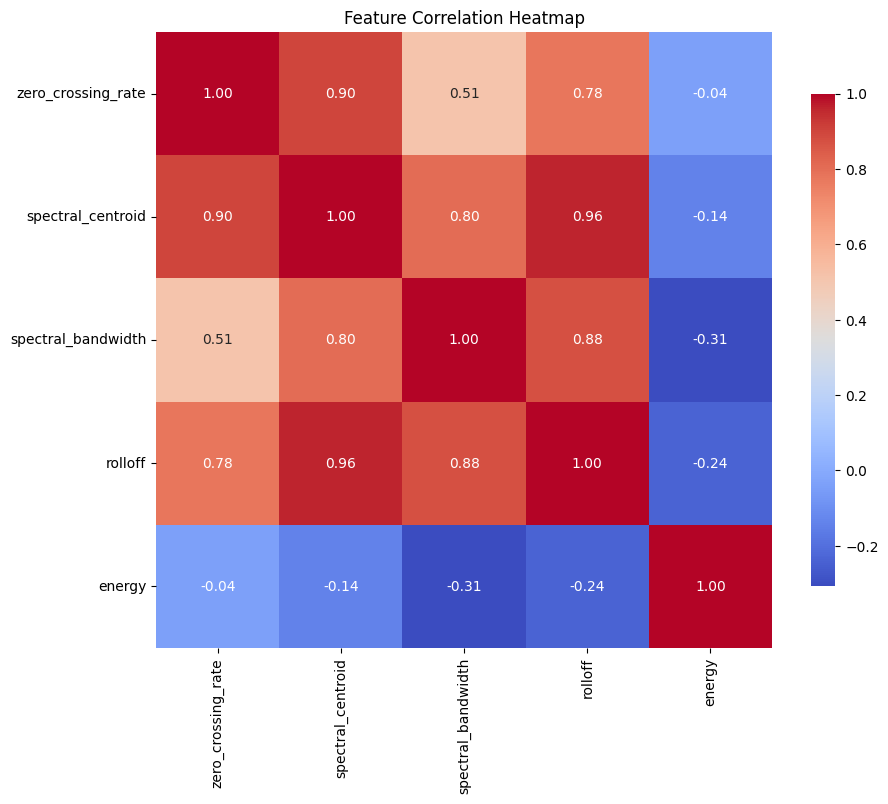

In [44]:
def extract_features(filepath, class_1_speakers):
    features_list = []

    # Load and compute features
    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        
        # Calculate features
        zcr = librosa.feature.zero_crossing_rate(audio).mean()
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr).mean()
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85).mean()
        energy = np.sum(librosa.feature.rms(y=audio))

        # Store features in a dictionary
        features = {
            'filename': file,
            'class': 'Class 1' if file.split('_')[0] in class_1_speakers else 'Class 0',
            'zero_crossing_rate': zcr,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'rolloff': rolloff,
            'energy': energy
        }
        features_list.append(features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    return features_df

def plot_correlation_heatmap(features_df):
    # Select only numeric columns for correlation
    numeric_features_df = features_df.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    correlation_matrix = numeric_features_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Heatmap')
    plt.show()

    
# Extract features
features_df = extract_features(filepath, class_1_speakers)

# Plot the correlation heatmap
plot_correlation_heatmap(features_df)


### As we can see from the plot, the dataset is imbalanced. To address that we need to implement data augmentation

In [15]:
sample_rate = 44100

In [6]:
def load_audio_files():
    audio_files = []
    for file in os.listdir(filepath):
        audio, _ = librosa.load(os.path.join(filepath, file),sr=None) # sr=None to keep the original sample rate = 44100 as the analysis has shown
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        audio_files.append(trimmed)
    return audio_files

audio = load_audio_files()

In [11]:
def split_audio(audio,duration = 5.0):
    samples_per_segment = duration * sample_rate
    segments = len(audio)
    return np.array_split(audio, int(segments/samples_per_segment))

def time_shift(audio, max_shift = 2.5):
    shift = np.random.uniform(-max_shift, max_shift)
    shift_samples = int(shift * sample_rate)
    return np.roll(audio, shift_samples)